In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from keras.regularizers import L2
from sklearn.preprocessing import *
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.base import *
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [69]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [37]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [38]:
train_data.drop(columns=['id'], inplace=True)
train_data.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [39]:
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

In [40]:
encoder = OrdinalEncoder()
scaler = StandardScaler()

In [41]:
train_data['NObeyesdad'] = encoder.fit_transform(train_data[['NObeyesdad']])

In [42]:
class Encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if 'NObeyesdad' in X.columns:
            for col in X.drop('NObeyesdad', axis=1).columns:
                if X[col].dtype=='object':
                    X[col] = encoder.fit_transform(X[[col]]).astype('float32')
        else:
            for col in X.columns:
                if X[col].dtype=='object':
                    X[col] = encoder.fit_transform(X[[col]]).astype('float32')
        return X

class Drop_Duplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.drop_duplicates(inplace=True)
        return X
    
class Data_Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if 'NObeyesdad' in X.columns:
            for col in X.drop('NObeyesdad', axis=1).columns:
                X[col] = scaler.fit_transform(X[[col]])
        else:
            for col in X.columns:
                X[col] = scaler.fit_transform(X[[col]])
        return X

class Outlier_Remover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        isolation_forest = IsolationForest(contamination=0.05)
        X["is_outlier"] = isolation_forest.fit_predict(X)
        X = X[X["is_outlier"] == 1]
        X.drop("is_outlier" ,axis = 1 ,inplace = True)
        return X

pipeline = Pipeline([
    ('encoding', Encoding()),
    ('drop_dupli', Drop_Duplicates()),
    ('scaling', Data_Scaling()),
    ('outliers', Outlier_Remover()),
])

In [43]:
train_data = pipeline.fit_transform(train_data)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_36/2065360254.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop("is_outlier" ,axis = 1 ,inplace = True)


In [44]:
train_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1.004152,0.105699,-0.002828,-0.235713,0.469099,0.30588,-0.836279,0.314684,0.337845,-0.109287,1.206594,-0.185009,-1.171141,0.597438,-0.471288,0.429319,6.0
1,-0.995866,-1.027052,-1.606291,-1.170931,0.469099,0.30588,-0.836279,0.338364,-1.889204,-0.109287,-0.048349,-0.185009,0.021775,0.636513,1.639846,-2.182324,1.0
2,-0.995866,-1.027052,0.128451,-1.430012,0.469099,0.30588,-1.060332,-1.913423,0.337845,-0.109287,-0.195644,-0.185009,-0.138022,1.755239,1.639846,0.429319,0.0
3,-0.995866,-0.507929,0.120090,1.644770,0.469099,0.30588,1.039171,0.338364,0.337845,-0.109287,-0.584035,-0.185009,0.579896,0.271455,-0.471288,0.429319,4.0
4,1.004152,1.371197,2.450367,0.224054,0.469099,0.30588,0.438397,-1.119801,0.337845,-0.109287,-0.081469,-0.185009,1.176486,0.523111,-0.471288,0.429319,6.0


<Axes: >

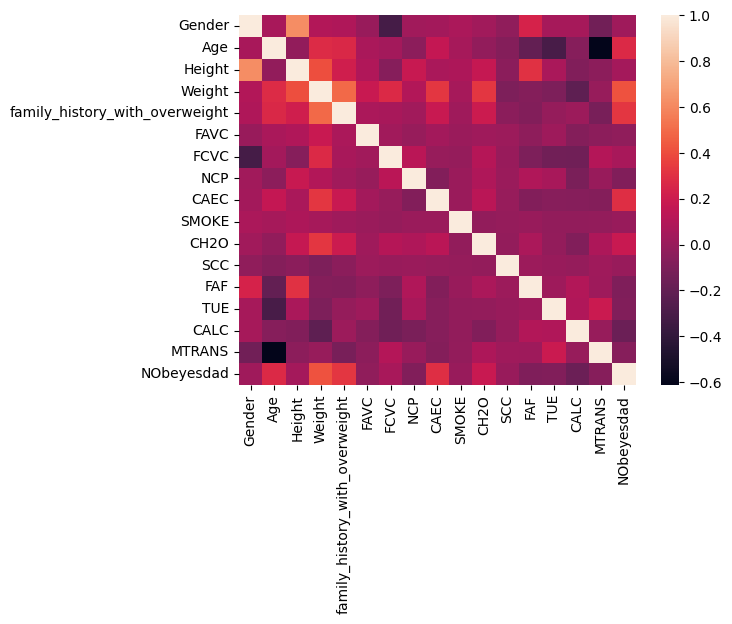

In [45]:
sns.heatmap(train_data.corr())

In [60]:
X = train_data.drop(columns=['NObeyesdad'])
Y = train_data['NObeyesdad'].astype('int')

y = np.zeros([Y.shape[0], 7])
y[np.arange(Y.shape[0]), Y] = 1

In [83]:
train_data['NObeyesdad'][10:20]

10     Overweight_Level_I
11          Normal_Weight
12         Obesity_Type_I
13       Obesity_Type_III
14          Normal_Weight
15        Obesity_Type_II
16    Overweight_Level_II
17          Normal_Weight
18    Overweight_Level_II
19        Obesity_Type_II
Name: NObeyesdad, dtype: object

In [84]:
Y[10:20]

10    5
11    1
12    2
13    4
15    3
17    1
18    6
19    3
20    6
21    1
Name: NObeyesdad, dtype: int64

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [62]:
model = Sequential([
    Dense(units=16, activation=None, kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dense(units=80, activation=None, kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dense(units=160, activation=None, kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dense(units=80, activation=None, kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dense(units=7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
model.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7400 - loss: 0.8116
Epoch 2/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7619 - loss: 0.7272
Epoch 3/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7722 - loss: 0.7030
Epoch 4/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7738 - loss: 0.7039
Epoch 5/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7762 - loss: 0.6821
Epoch 6/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7710 - loss: 0.6796
Epoch 7/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7919 - loss: 0.6236
Epoch 8/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7963 - loss: 0.6358
Epoch 9/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7980 - loss: 0.6156
Epoch 10/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8014 - loss: 0.6086
Epoch 11/100
986/986 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7940 - loss: 0.6288
Epoch 12/100
986/986 ━━━━━━━━━━━━━━━━━━━━

In [65]:
model.evaluate(X_test,y_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8724 - loss: 0.4238


[0.4317854940891266, 0.8681541681289673]

In [71]:
test_ids = test_data['id']
test_data.drop(columns=['id'], inplace=True)

In [72]:
pipeline_test = Pipeline([
    ('encoding', Encoding()),
    ('scaling', Data_Scaling()),
])

In [73]:
test_data = pipeline_test.fit_transform(test_data)

In [86]:
pred = model.predict(test_data)
pred = [np.argmax(p) for p in pred]
for i in range(len(pred)):
    if pred[i]==0:
        pred[i] = 'Insufficient_Weight'
    elif pred[i]==1:
        pred[i] = 'Normal_Weight'
    elif pred[i]==2:
        pred[i] = 'Obesity_Type_I'
    elif pred[i]==3:
        pred[i] = 'Obesity_Type_II'
    elif pred[i]==4:
        pred[i] = 'Obesity_Type_III'
    elif pred[i]==5:
        pred[i] = 'Overweight_Level_I'
    elif pred[i]==6:
        pred[i] = 'Overweight_Level_II'

433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [87]:
submission = pd.DataFrame({'id': test_ids, 'NObeyesdad': pred})

submission.to_csv('submission.csv', index=False)